In [ ]:
# Bibliotecas para manipulação de dados
import pandas as pd
import json

# Manipulação de sistema para ajustar paths de importação
import sys
import os

# Adiciona o caminho até a pasta que contém o configs.py no sys.path
sys.path.append(os.path.abspath('../'))

#chamando a função do módulo configs.py que mapeia as pastas no ambiente
import configs as cf
cf.mapeia_pastas()

from functions import ingestao, carregar_tabela_etl, NPS_populacao, join_classificado_x_geoloc, extrair_ultima_interacao, gerar_graficos_sentimento

from IA_Gen_analiser import classificar_acordo_openai # AJUSTAR CHAVE DA OPENAI no arquivo em 'models/IA_Gen_analiser.py'

from send_emails import enviar_email_relatorio

✅ DataFrame criado com sucesso! Use a coluna 'Email Ouvidoria (Censo Recomendado)'.
✅ DataFrame Gerado com Sucesso! (Apenas DDD mantido)
✅ Cliente OpenAI inicializado com sucesso.


========================== INICIANDO EXECUÇÃO ==========================
============= 1. Carregando dados e fazendo Ingestão =============
============= Dados carregados com sucesso =============
============= 2. Classificação de Sentimentos =============

[CLASSIFICADOR IA GENERATIVA] Iniciando classificação via API OpenAI (gpt-4o-mini)...
[CLASSIFICADOR IA GENERATIVA] Classificação concluída.
✅ Coluna 'Sentimento_Populacao' criada com sucesso.
============= Dados classificados com sucesso =============
============= 3. Criando tabelas finais =============
============= Tabelas criadas com sucesso =============
============= 4. Gerando Analytics =============

🚨 Erro ao salvar como JPG (FigureCanvasAgg.print_jpg() got an unexpected keyword argument 'quality'). Tentando salvar como PNG...
✅ Gráfico salvo como PNG: relatorio_sentimento.jpg


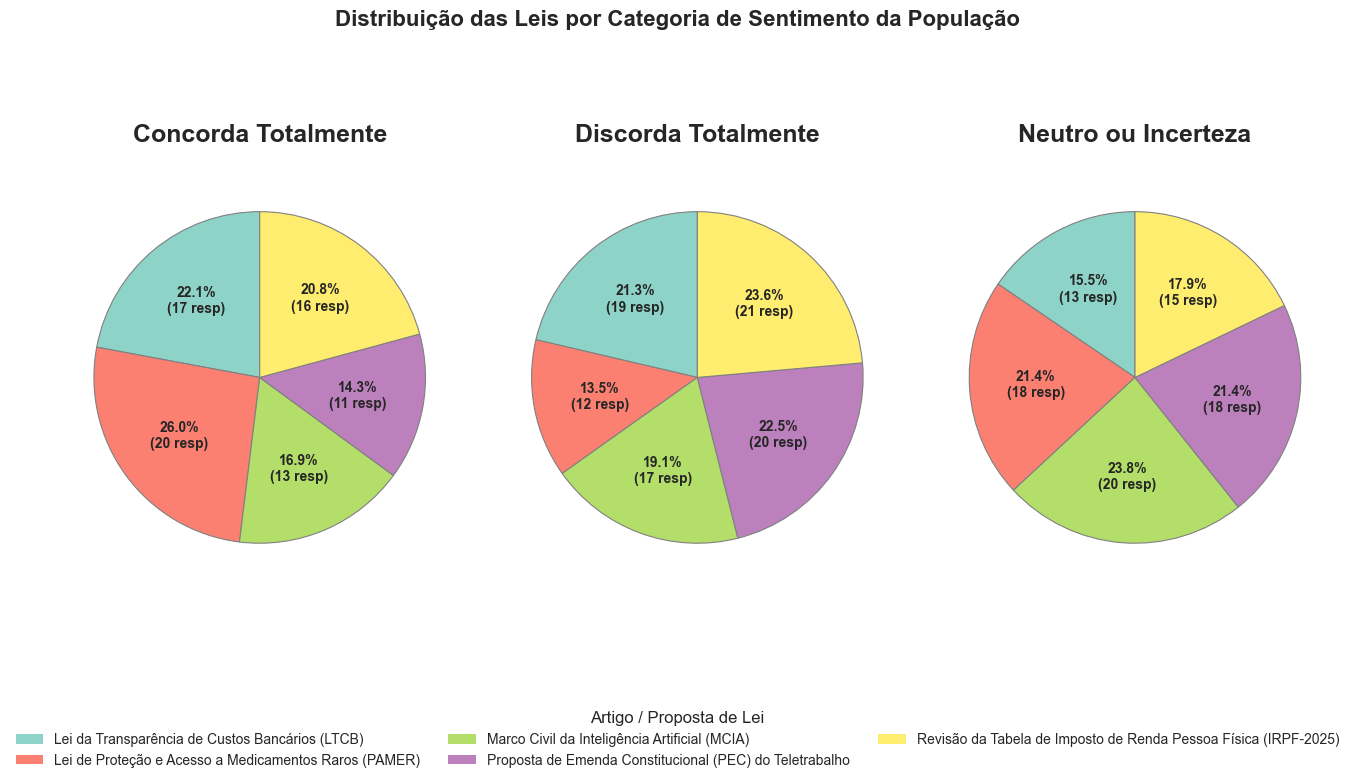

============= Analytics gerados com sucesso =============
============= 5. Enviando estatísticas por e-mail =============
Iniciando envio de E-mail.

✅ E-mail de relatório enviado com sucesso para ['lelicontato@gmail.com', 'lucas.correia.sas@gmail.com', 'gabriel-nichols@hotmail.com']!
============= E-mails enviados com sucesso =============
========================== EXECUÇÃO FINALIZADA COM SUCESSO ==========================


In [4]:
if __name__ == '__main__':
    
    print("========================== INICIANDO EXECUÇÃO ==========================")

    print("============= 1. Carregando dados e fazendo Ingestão =============")
    ingestao()
    geoloc = carregar_tabela_etl("geolocalizacao_orgs")
    interact = carregar_tabela_etl("tbl_interacao_usuario")
    print("============= Dados carregados com sucesso =============")

    print("============= 2. Classificação de Sentimentos =============")
    df_classificado = classificar_acordo_openai(interact)
    df_classificado['Ultima_Interacao_Usuario'] = df_classificado['Interacao_usuario'].apply(extrair_ultima_interacao)
    df_classificado_final = NPS_populacao(df_classificado)
    print("============= Dados classificados com sucesso =============")

    print("============= 3. Criando tabelas finais =============")
    df_cruzado_final = join_classificado_x_geoloc(df_classificado_final, geoloc.copy())
    # Anexo do email:
    df_attachment = df_cruzado_final[['anomesdia','UF','Artigo_Proposta_Lei','Ultima_Interacao_Usuario','Sentimento_Populacao']]
    df_attachment.to_csv('df_attachment.csv', index=False, sep=';', encoding='latin-1')
    print("============= Tabelas criadas com sucesso =============")

    print("============= 4. Gerando Analytics =============")
    # Estatísticas do Body:
    df_agrup_QTD = df_cruzado_final.groupby(['Artigo_Proposta_Lei','Sentimento_Populacao']).agg({'Interacao_usuario':'count'}).reset_index()
    df_agrup_SUM = df_agrup_QTD.groupby(['Artigo_Proposta_Lei','Sentimento_Populacao']).agg({'Interacao_usuario':'sum'}).reset_index()
    # Gráficos de sentimentos:
    gerar_graficos_sentimento(df_agrup_SUM, nome_arquivo="relatorio_sentimento.jpg")
    print("============= Analytics gerados com sucesso =============")

    print("============= 5. Enviando estatísticas por e-mail =============")
    enviar_email_relatorio(df_attachment)
    print("============= E-mails enviados com sucesso =============")

    print("========================== EXECUÇÃO FINALIZADA COM SUCESSO ==========================")
